<a href="https://colab.research.google.com/github/akbardwi/Ripe-AI/blob/main/Machine%20Learning/Script/Training_Model_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalau Mau Pakai Directory di Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Semua Dependencies

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, RMSprop,Adam
from tensorflow.keras.models import model_from_json
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

Set Directory Dataset

In [3]:
BASE_DIR = '/content/drive/MyDrive/Dataset/Banana'      # Directory dataset 
TRAINING_DIR    = os.path.join(BASE_DIR, 'Training')
TESTING_DIR     = os.path.join(BASE_DIR, 'Test')
VALIDATION_DIR  = os.path.join(BASE_DIR, 'Validation')

Bikin Image Generator

In [4]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=64
)

testing_generator = validation_datagen.flow_from_directory(
	TESTING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=64
)

Found 506 images belonging to 3 classes.
Found 146 images belonging to 3 classes.
Found 74 images belonging to 3 classes.


Import Pre-Trained Model

In [5]:
inception_model = InceptionV3(input_shape = (150, 150, 3),    # ukuran input gambar
                                include_top = False,          # hilangkan layer dense
                                weights = 'imagenet')         # pakai data weight langsung dari imagenet

87924736/87910968 [==============================] - 1s 0us/step


In [6]:
# inception_model.summary()

In [7]:
last_layer = inception_model.get_layer('mixed5')           # coba eksperimen dengan layer yang berbeda
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Bikin Layer untuk Output Model

In [8]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)      # coba eksperimen dengan banyak layer yang berbeda
x = layers.Dropout(0.2)(x)                        # coba eksperimen dengan nilai dropout yang berbeda
x = layers.Dense(3, activation='softmax')(x)           

model = Model(inception_model.input, x) 

# model.summary()

Compile Model

In [10]:
model.compile(optimizer = Adam(),               # coba eksperimen dengan optimizer yang berbeda
              loss = 'binary_crossentropy',     # coba eksperimen dengan loss function yang berbeda
              metrics = ['accuracy'])

Fit Data to Model

In [26]:
history = model.fit(train_generator, epochs=25, steps_per_epoch=8, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/25
8/8 [==============================] - 6s 746ms/step - loss: 0.0138 - accuracy: 0.9901 - val_loss: 0.1795 - val_accuracy: 0.9521
Epoch 2/25
8/8 [==============================] - 6s 726ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.3760 - val_accuracy: 0.9452
Epoch 3/25
8/8 [==============================] - 6s 725ms/step - loss: 0.0133 - accuracy: 0.9941 - val_loss: 0.2640 - val_accuracy: 0.9452
Epoch 4/25
8/8 [==============================] - 6s 727ms/step - loss: 0.0097 - accuracy: 0.9960 - val_loss: 0.2524 - val_accuracy: 0.9315
Epoch 5/25
8/8 [==============================] - 6s 725ms/step - loss: 0.0107 - accuracy: 0.9901 - val_loss: 0.4725 - val_accuracy: 0.9384
Epoch 6/25
8/8 [==============================] - 6s 720ms/step - loss: 0.0132 - accuracy: 0.9921 - val_loss: 1.0175 - val_accuracy: 0.8562
Epoch 7/25
8/8 [==============================] - 6s 722ms/step - loss: 0.0254 - accuracy: 0.9822 - val_loss: 0.2679 - val_accuracy: 0.9589
Epoch 8/25
8/8 [====

In [27]:
skill = model.evaluate(testing_generator)

2/2 [==============================] - 0s 39ms/step - loss: 0.2842 - accuracy: 0.9189


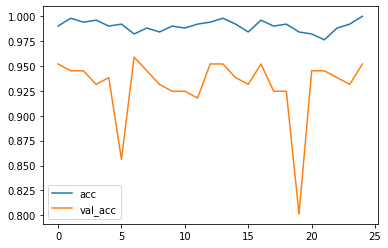

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

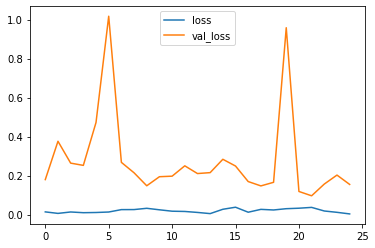

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

Saving download (11).jpeg to download (11) (1).jpeg
Saving download (12).jpeg to download (12) (1).jpeg
Saving download (13).jpeg to download (13).jpeg
Saving download (14).jpeg to download (14).jpeg
Saving download (15).jpeg to download (15) (1).jpeg
download (11).jpeg [[0. 0. 1.]]
download (12).jpeg [[0. 0. 1.]]
download (13).jpeg [[0. 0. 1.]]
download (14).jpeg [[0. 0. 1.]]
download (15).jpeg [[0. 0. 1.]]


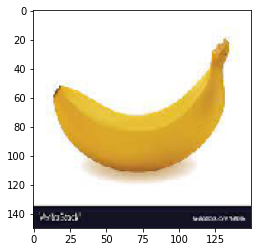

In [30]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
  
uploaded = files.upload()
  
for fn in uploaded.keys():
  
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn, classes)

  

Saved Model ke TFLite

In [ ]:
import pathlib

# Export model
EXPORT_DIR = '/content/exportmodel'     # Directory export
tf.saved_model.save(model, EXPORT_DIR)

# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(EXPORT_DIR)
tflite_model = converter.convert()      

# Save model
tflite_model_file = pathlib.Path('/content/foo.tflite')
tflite_model_file.write_bytes(tflite_model)

Save Model ke TF Serving

In [ ]:
import tempfile

MODEL_DIR = '/content/model/Banana'        # Directory model. Apakah harus pakai temp directory?
version = 1
EXPORT_PATH = os.path.join(MODEL_DIR, str(version))   # Path version model
if os.path.isdir(EXPORT_PATH):
  print("\nPath already exist, cleaning up\n")
  !rm -r {EXPORT_PATH}

tf.keras.models.save_model(
    model,
    EXPORT_PATH,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print("\nSaved model:")
!ls -l {EXPORT_PATH}

INFO:tensorflow:Assets written to: /content/model/Banana/1/assets

Saved model:
total 3052
drwxr-xr-x 2 root root    4096 Jun  6 13:41 assets
-rw-r--r-- 1 root root  347018 Jun  6 13:41 keras_metadata.pb
-rw-r--r-- 1 root root 2768481 Jun  6 13:41 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  6 13:41 variables


In [ ]:
!zip -r /content/Banana.zip /content/model/Banana

  adding: content/model/Banana/ (stored 0%)
  adding: content/model/Banana/1/ (stored 0%)
  adding: content/model/Banana/1/saved_model.pb (deflated 92%)
  adding: content/model/Banana/1/assets/ (stored 0%)
  adding: content/model/Banana/1/variables/ (stored 0%)
  adding: content/model/Banana/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/Banana/1/variables/variables.index (deflated 79%)
  adding: content/model/Banana/1/keras_metadata.pb (deflated 95%)


In [ ]:
from google.colab import files
files.download('/content/Banana.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/Banana.zip /content/drive/MyDrive/

In [ ]:
!saved_model_cli show --dir {EXPORT_PATH} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 150, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          input_1: TensorS